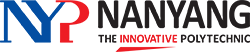

# ITB251 Assignment - Task 2: Topic Modelling

You are required to build a topic model to help understand the text in the review to a particular topic. This analysis aims to be accompaniment to the results of the sentiment classification and helps businesses to identify main topic that customers are concern about.

Complete the following sub-tasks:
1.	**Data Understanding**: Examine the dataset
2.	**Data Preparation**: Prepares the data and all necessary pre-processing tasks
3.	**Modelling**: Identify the suitable topic number for the topic model
4.	**Evaluation**: Evaluates the results and identify the topic

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in the Jupyter notebook**. 

**Done by: \<Enter your name and admin number here\>**

## Import libraries and download the packages

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora

## Read the dataset

In [2]:
df = pd.read_csv("shopping_reviews.csv")
# pd.set_option("display.max_colwidth", None)
df.head()

,Unnamed: 0,review_id,date,name,categories,text,stars
0,15,Af6Jnf8F5xBliuixStWF8g,2019-09-20,"""Soccer Zone""",Shopping;Sporting Goods,I'll admit it. I caught World Cup fever in 20...,4
1,18,j-6-I55-9EiKNGAjoLHx9A,2020-06-30,"""Fye""",Shopping;Books;Mags;Music & Video;Music & DVDs,This store has gone through some management ch...,4
2,46,wCwl4NC1CxkRIAg2RcLzig,2020-09-28,"""By Design""",Home & Garden;Furniture Stores;Shopping,By Design sells funky ultra modern furniture. ...,3
3,73,PwSZrByRWrZ5x7QTq7V2PA,2020-05-10,"""Star Nursery""",Nurseries & Gardening;Home & Garden;Shopping,"I don't have much of a greenthumb, thankfully ...",4
4,82,yHmRAHgjgqucJcUG3to7-Q,2020-08-26,"""Sports Authority""",Sporting Goods;Shopping,I am only ever going to this Sports Authority ...,5


## Data Understanding

In [3]:
# Checking the shape of the datframe
print("Number of records in the dataframe:",df.shape[0])
print("Number of columns in the dataframe:",df.shape[1])

Number of records in the dataframe: 36422
Number of columns in the dataframe: 7


In [4]:
print("Columns in the dataframe:")
print(list(df.columns))

Columns in the dataframe:
['Unnamed: 0', 'review_id', 'date', 'name', 'categories', 'text', 'stars']


In [5]:
# Checking the column index and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36422 entries, 0 to 36421
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  36422 non-null  int64 
 1   review_id   36422 non-null  object
 2   date        36422 non-null  object
 3   name        36422 non-null  object
 4   categories  36422 non-null  object
 5   text        36422 non-null  object
 6   stars       36422 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.9+ MB


The index of the dataframe ranges from 0 to 36421.

The datatype of the columns seem to be correct.

In [6]:
# Checking nulls
print("Percentage of null in the columns:")
df.isna().sum()/df.shape[0]

Percentage of null in the columns:


Unnamed: 0    0.0
review_id     0.0
date          0.0
name          0.0
categories    0.0
text          0.0
stars         0.0
dtype: float64

There are no null values in any of the columns.

### Data Understanding - Columns 'Unnamed: 0' and 'review_id'

In [7]:
print("How unique are the Unnamed: 0 and review_id?")
print("Uniqueness Percentage of column 'Unnamed: 0':",(df['Unnamed: 0'].nunique()/df.shape[0])*100)
print("Uniqueness Percentage of column 'review_id':",(df['review_id'].nunique()/df.shape[0])*100)

How unique are the Unnamed: 0 and review_id?
Uniqueness Percentage of column 'Unnamed: 0': 100.0
Uniqueness Percentage of column 'review_id': 100.0


A uniqueness percentage of 100% means that it is 100% unique.

These columns are unique identifiers for each record in the dataframe. They have high dimensionality and are not relevant to the target, which is to classify the positive and negative texts. Therefore, these columns will be removed later.

### Data Understanding - Columns 'date'

In [8]:
print("Earlist text recorded:",df.date.min())
print("Latest text recorded:",df.date.max())

Earlist text recorded: 2019-01-01
Latest text recorded: 2020-12-31


The dataframe contains data from 2019 to 2020, 2 years worth of data.

In [9]:
df['yyyy-mm'] = pd.to_datetime(df.date).dt.strftime('%Y-%m')

In [10]:
months = sorted(df['yyyy-mm'].unique())
occurrence = list(df.groupby('yyyy-mm').size())

In [11]:
occurrence_month = list(zip(months, occurrence))

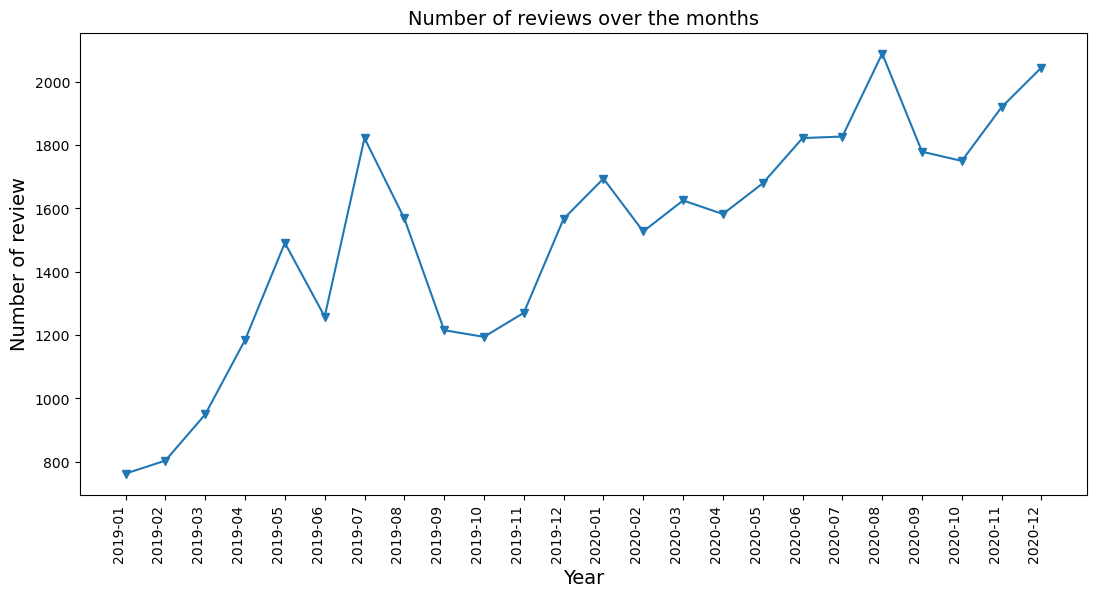

In [12]:
# Checking the distribution of reviews across the time period
fig = plt.figure(figsize=(13, 6))
plt.plot(sorted(df['yyyy-mm'].unique()), df.groupby('yyyy-mm').size(), marker='v')
plt.xticks(rotation=90, ha='right')
plt.title('Number of reviews over the months', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of review', fontsize=14)
plt.show()

In [13]:
print("Difference between the highest and lowest number of reviews:",max(occurrence)-min(occurrence))

Difference between the highest and lowest number of reviews: 1327


Based on the line chart, the spread of reviews across the months is fairly distributed with each month having at least 700 records. The difference between the highest and lowest review months being 1327 reviews.

### Data Understanding - Columns 'name'

In [14]:
print("Number of unique store names in the dataframe:",df.name.nunique())

Number of unique store names in the dataframe: 7475


This dataframe contains lots of unique store names. Therefore, I will not analyze the spread of sentiment across individual stores.

In [15]:
# Check if the top store name is null or any weird value.
df.name.value_counts()

"Encore"                          408
"Trader Joe's"                    395
"Target"                          313
"Walmart Supercenter"             306
"Total Wine & More"               246
                                 ... 
"David's Shoes"                     1
"Yes of Course"                     1
"Sporting Life Bikes & Boards"      1
"Million Tapis et Tuiles"           1
"Fresh Boutique"                    1
Name: name, Length: 7475, dtype: int64

Based on the counts, there seems to not have any weird values apart from occasional weird store names such as 'Yes of Course'.

In [16]:
print("Percentage of stores that have 1 review only in the dataframe:",round((((df.groupby(df.name.tolist()).size() == 1).sum())/df.shape[0])*100),"%")

Percentage of stores that have 1 review only in the dataframe: 8 %


The number of stores that have only 1 review make up roughly 8% of the records in the dataframe.

The other 92% belongs to stores that have more than 1 reviews of their store.

### Data Understanding - Columns 'categories'

In [17]:
print("Number of unique categories in the dataframe:",df.categories.nunique())

Number of unique categories in the dataframe: 6568


In [18]:
df.categories.head()

0                           Shopping;Sporting Goods
1    Shopping;Books;Mags;Music & Video;Music & DVDs
2           Home & Garden;Furniture Stores;Shopping
3      Nurseries & Gardening;Home & Garden;Shopping
4                           Sporting Goods;Shopping
Name: categories, dtype: object

The categories seem to be clustered with a separator ';'. 

Therefore, the value 6568 identified earlier represents the unique group of categories, not the individual categories.

In order to have a better data exploration, these categories need to be separated.

In [19]:
# Store the categories in a list for manipulation.
categories = [category for category in df['categories']]

In [20]:
# Iterate through the list and substitute the ';' with spaces.
# Convert categories with '&' to be joined with an underscore.
strip = list(map(lambda x: re.sub(';', ' ', re.sub('[ &()]+', '_', x)), categories))
strip[:5]

['Shopping Sporting_Goods',
 'Shopping Books Mags Music_Video Music_DVDs',
 'Home_Garden Furniture_Stores Shopping',
 'Nurseries_Gardening Home_Garden Shopping',
 'Sporting_Goods Shopping']

In [21]:
# Tokenize the individual categories
tokenized_category_list = [sorted(nltk.word_tokenize(category)) for category in strip]

In [22]:
# This stores all the categories from the original categories column, regardless of duplicates
category_list = []
for lists in tokenized_category_list:
    for category in lists:
        category_list.append(category)

In [23]:
unique_categories = set(category_list)

In [24]:
print('Number of unique categories in the dataframe:',len(unique_categories))

Number of unique categories in the dataframe: 678


In [25]:
print("Example of categories in the dataframe")
list(unique_categories)[:5]

Example of categories in the dataframe


['Formal_Wear',
 'Wholesale_Stores',
 'Candle_Stores',
 'Art_Galleries',
 'Jewelry_Repair']

In [26]:
print("Top 10 categories in the dataframe")
pd.value_counts(category_list).head(10)

Top 10 categories in the dataframe


Shopping             36422
Fashion              11061
Food                  5150
Home_Garden           4994
Women's_Clothing      4346
Flowers_Gifts         3191
Department_Stores     3188
Music_Video           2796
Mags                  2796
Books                 2796
dtype: int64

The categories give a general idea of what type of stores the texts are from. 

The texts are from mostly related to shopping, fashion, food, and others.

### Data Understanding - Columns 'text'

In [27]:
df.text.head()

0    I'll admit it.  I caught World Cup fever in 20...
1    This store has gone through some management ch...
2    By Design sells funky ultra modern furniture. ...
3    I don't have much of a greenthumb, thankfully ...
4    I am only ever going to this Sports Authority ...
Name: text, dtype: object

This will be the column used for text classification. It contains the customer's review toward the store and contains words that affect the overall text sentiment.

In [28]:
print("Percentage of unique texts in the dataframe",(df.text.nunique()/df.shape[0])*100,"%")

Percentage of unique texts in the dataframe 99.97254406677283 %


There seem to have some duplicates in the text since the percentage is not 100% unique.

### Data Understanding and Preparation - Checking and Removing duplicates in text column.

In [29]:
print("Percentage of unique texts in the dataframe",(df.text.nunique()/df.shape[0])*100,"%")

Percentage of unique texts in the dataframe 99.97254406677283 %


In [30]:
print("Number of duplicated texts:",len(df[df.duplicated(subset='text')]))

Number of duplicated texts: 10


In [31]:
df[df.duplicated(subset='text')].head()

,Unnamed: 0,review_id,date,name,categories,text,stars,yyyy-mm
4454,44208,ap04xvg5qzR3Z_NyplaWoQ,2019-07-03,"""Clinton Cards""",Art Supplies;Shopping;Flowers & Gifts;Cards & ...,I have to be honest and say I don't really see...,2,2019-07
20561,212655,063_M7x370zH_tTPsSkTzQ,2020-11-04,"""Ace Hardware""",Hardware Stores;Home & Garden;Shopping,Union Hills Ace Hardware is really great.. the...,5,2020-11
21345,221974,q2gxE-9bxP85opJGS5bm3A,2020-12-31,"""Urban Outfitters""",Home & Garden;Fashion;Women's Clothing;Shoppin...,Score! When I went over Christmas they were ha...,4,2020-12
21510,223196,RPj6HJ25oV5KqH-dbgkYhA,2020-02-20,"""Sephora""",Cosmetics & Beauty Supply;Beauty & Spas;Shopping,I love Sephora. The associates are always fri...,5,2020-02
23959,246519,6lpuDI4PrrUY_5lWcV8vug,2020-05-10,"""Mega Furniture""",Home & Garden;Furniture Stores;Shopping;Mattre...,Too good to be true...because its not true! I ...,1,2020-05


Looking at the text duplicates, the length of the texts are long and highly unlikely that the reviewers wrote the same text as another person. Thus, I will drop these records to prevent overfitting and reduce noise in the model.

In [32]:
# Drop the duplicates
df = df.drop_duplicates(subset=['text'])

In [33]:
# Resetting the index of the dataframe
df = df.reset_index(drop=True)

In [34]:
print("Number of records in the dataframe now:",df.shape[0])

Number of records in the dataframe now: 36412


### Data Understanding - Columns 'star'

Total records: 36412


stars,occurrences,occurrences (%)
5,12606,34.62%
4,11983,32.91%
3,5691,15.63%
1,3326,9.13%
2,2806,7.71%


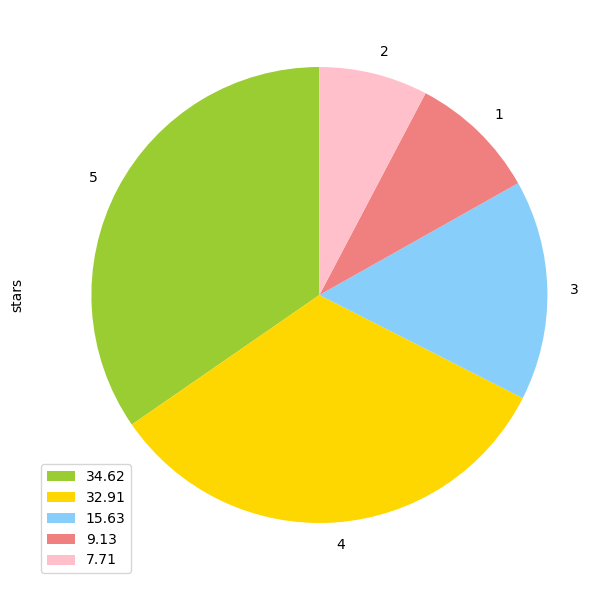

In [35]:
# Checking the distribution of the stars
stars = pd.DataFrame({'occurrences': df['stars'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df)*100), 2))+"%" for x in df['stars'].value_counts()]}).rename_axis(columns="stars")
print("Total records:", sum(stars['occurrences']))
display(stars)

labels = round((df['stars'].value_counts()/len(df)*100),2)
sizes = round((df['stars'].value_counts()/len(df)*100),2)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'pink']
(df['stars'].value_counts()/len(df)*100).plot(kind='pie', figsize=(14,6), colors=colors, startangle=90)
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

The distribution of ratings is unbalanced, with ratings of 4 and 5 contributing to 67.53% of the records in the dataframe, while ratings of 1 to 3 contributing only 32.47%. The spread of ratings reveals that majority of the reviewers gave their stores a rating of 4 to 5.

### Data Understanding - Checking the Word and Word Length Distribution

In [36]:
# Store reviews in a variable
reviews = [review.lower() for review in df['text']]

In [37]:
# Tokenize the words
from nltk.tokenize import word_tokenize

tokenized_words = [word_tokenize(review) for review in reviews]

In [38]:
# Get the tokenized words
tokenized_word_list = [word for word_lists in tokenized_words for word in word_lists]

# Get the word lengths
word_lengths = [len(word) for word in tokenized_word_list]

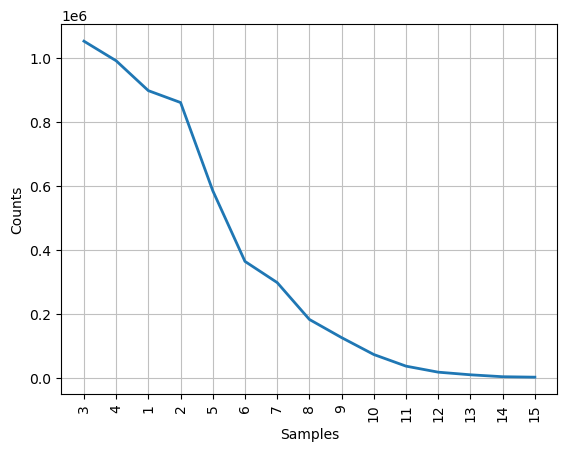

In [39]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(word_lengths)

# Visualizing 
word_length_frequency_dict = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(word_length_frequency_dict)

# plot the frequency distribution of the top 50 words
freq_dist.plot(15, cumulative=False)
plt.show()

### Identifying odd words that need to be removed.

These words will create noise during sentiment analysis. Therefore, to ensure optimal model performance, these specific odd words will be removed without removing potentially useful terms.

#### Identifying words with odd lengths

In [40]:
# At word lengths of more than 10, the curve starts to flat line.
# Therefore, look at the words with length above 10.

odd_lengths = [words for words in tokenized_word_list if len(words)>10]
print(odd_lengths[:10])

['well-stocked', 'neighborhood', 'disappointed', 'accompanied', 'recommended', 'immediately', '\\/\\/www.yelp.com\\/biz_photos\\/xpzt3zlrklkfskbvxssm3w', 'select=n2iluoe8xdytbiowpfnp3q', 'wedding-related', 'researching']


- There seems to be some links in the texts such as "\\/\\/www.yelp.com\\/biz_photos\\/xpzt3zlrklkfskbvxssm3w". These links start with '\\\\\/'

- There also seems to be SQL-like statements such as "select=n2iluoe8xdytbiowpfnp3q"

- Lastly, the word "\\\\/" seems like it is used as a slash in the links.

In [41]:
# Confirming if '\\\\/' is used as a slash
slashed_words = [words for words in tokenized_word_list if '\\/' in words]
print(slashed_words[5:20])

['eastern\\/euro', 'soilwork\\/death', 'patio\\/sliding', 'bought\\/returned', '£5\\/10', 'situations\\/patrons', 'board\\/ride', 'w\\/', 'goods\\/looks', 'sf\\/us', 'you\\/goodbye', 'furniture\\/bigger', 'month\\/year', 'and\\/or', 'current\\/elloitt']


To confirm, the \\\\/ is used as a slash.

In [42]:
# Checking for words with '.' in odd length words
# This could help us identify website links within the words with long lengths
dots_in_text = [word for word in odd_lengths if '.' in word]
print(dots_in_text[:10])

['\\/\\/www.yelp.com\\/biz_photos\\/xpzt3zlrklkfskbvxssm3w', 'abebooks.com', 'store.highly', '....................', '...............................', 'www.bohofarmandhome.com', 'bohofarmandhome.com', '21.99-24.99', '\\/\\/www.saleevent.ca\\/index.php', 'responds.anyway']


- Looks like there are some links aside from the yelp link identified above.
- Some links start with www while others end with their domain names.
- There are words that could have been typed wrongly e.g., store.highly

In [43]:
# Checking for domain names
# Since .com is a domain name, 
# I try to find other domain names and remove words containing them.

# pattern to identify the domain names at the end of the words
pattern = '\.[\w+\d+]+$'

organizations = [re.findall(pattern, words) for words in dots_in_text if re.findall(pattern, words)]

compiled_values = [value for lists in organizations for value in lists]

compiled_array = np.array(compiled_values)
occurrence = list(zip(*np.unique(compiled_array, return_counts=True)))

# Store the domain names
domains_names = ['('+str(entry[0].strip('.'))+')' for entry in occurrence if entry[1]>1]

In [44]:
domain_names = sorted(domains_names, key=len, reverse=True)
# Sort them based on their length so that domains such as 'html' will not be replaced by 
# 'htm' instead of 'html'.
regex_domain_names = '|'.join(domain_names)
regex_domain_names

'(hopefully)|(customer)|(anyway)|(highly)|(their)|(there)|(also)|(aspx)|(html)|(save)|(then)|(they)|(this)|(time)|(what)|(all)|(and)|(asp)|(cfm)|(com)|(htm)|(jpg)|(net)|(now)|(org)|(pdf)|(php)|(she)|(the)|(yes)|(you)|(99)|(ca)|(de)|(if)|(it)|(on)|(uk)|(we)|(i)'

This list of domain names will be used for pattern matching later.

In [45]:
# Checking for words with '.' in odd length words
# This could help us identify website links within the words with long lengths
colon_text = [word for word in tokenized_word_list if ':' in word]
print(colon_text[:10])

[':', ':', ':', ':', ':', ':', '5:00', '5:30pm', ':', ':']


In [46]:
http_occurrences = [words for words in odd_lengths if ':' in words]
print(http_occurrences[:5])

['2:30-5:15pmish', 'hrid:9eqwucmwj79em_obubuyha', '09:00-11:00.', 'hrid:8sbuwg4ynpop5v-kky3-ca', 'hrid:8cycftibywz9x9z841mq_g\\/src']


There are some colons in the text.

In [47]:
print([word for word in tokenized_word_list if '=' in word][:10])

['select=n2iluoe8xdytbiowpfnp3q', '=', '=', 'two=', '=', '=p', '=p', '=d', '=', 'select=apvssppowbz3lb0ob4saua']


Seems like most of the SQL-like syntax has numbers, punctuations, or special characters in the words following the "=".

In [48]:
http_occurrences = [words for words in tokenized_word_list if 'http' in words]
print(http_occurrences[:5])

['http', 'http', 'http', 'http', 'http']


There are some 'http' words in the tokenized words. There seems to not have any links, but just http

In [49]:
print([http for http in http_occurrences if len(http)>4])

['https', 'https', 'https', 'https', 'https', 'https', 'guisehttp', 'https', 'https']


Looks like there are https and words in front of http, but not any link. Therefore, these needs to be removed.

### Checking the word distribution

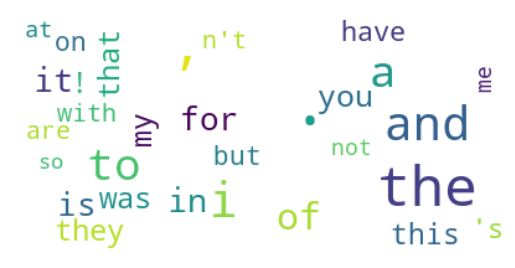

In [50]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(tokenized_word_list)

# Visualizing 
words = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(words)

# build wordcloud
from wordcloud import WordCloud
wcloud = WordCloud(max_font_size=50, max_words=30, background_color="white").generate_from_frequencies(freq_dist)

# plot the wordcloud
import matplotlib.pyplot as plt
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Words with high frequency appear larger in the word cloud.

Based on the top 30 words in the word cloud, the frequently occuring words are mostly stopwords or punctuations. These words occur frequently in all documents and will cause noise in the sentiment classifcation. Thus, it will be removed later to reduce the noise in the machine, potentially improving the model's performance.

## Data Preparation

Some data cleaning made to reduce the noise within the dataframe.

In [51]:
print("Number of records in the dataframe:",df.shape[0])

Number of records in the dataframe: 36412


In real world context, running a model on 36k records is both computational and time consuming. Therefore, I will sample one third of the original dataset for modelling.

### Removing Unnecessary Columns to improve processing performance

Removing 'review_id' and 'Unnamed: 0'. As identified earlier, they are unique identifiers, have high dimensionality, and have no effect on the text's sentiment.

Removing 'date', 'categories' and 'name'. These columns have no effect on the text's sentiment nor will it be used.

Therefore, these columns are removed due to its low relevancy.

In [52]:
df.head()

,Unnamed: 0,review_id,date,name,categories,text,stars,yyyy-mm
0,15,Af6Jnf8F5xBliuixStWF8g,2019-09-20,"""Soccer Zone""",Shopping;Sporting Goods,I'll admit it. I caught World Cup fever in 20...,4,2019-09
1,18,j-6-I55-9EiKNGAjoLHx9A,2020-06-30,"""Fye""",Shopping;Books;Mags;Music & Video;Music & DVDs,This store has gone through some management ch...,4,2020-06
2,46,wCwl4NC1CxkRIAg2RcLzig,2020-09-28,"""By Design""",Home & Garden;Furniture Stores;Shopping,By Design sells funky ultra modern furniture. ...,3,2020-09
3,73,PwSZrByRWrZ5x7QTq7V2PA,2020-05-10,"""Star Nursery""",Nurseries & Gardening;Home & Garden;Shopping,"I don't have much of a greenthumb, thankfully ...",4,2020-05
4,82,yHmRAHgjgqucJcUG3to7-Q,2020-08-26,"""Sports Authority""",Sporting Goods;Shopping,I am only ever going to this Sports Authority ...,5,2020-08


In [53]:
# Removing the columns
df = df.drop(columns=['review_id', 'date', 'categories', 'name', 'yyyy-mm', 'stars'])

In [54]:
df.head()

,Unnamed: 0,text
0,15,I'll admit it. I caught World Cup fever in 20...
1,18,This store has gone through some management ch...
2,46,By Design sells funky ultra modern furniture. ...
3,73,"I don't have much of a greenthumb, thankfully ..."
4,82,I am only ever going to this Sports Authority ...


### Data Preparation - Removing Pattern Words

In [55]:
# Store texts in a variable
reviews = [review.lower() for review in df['text']]

In [56]:
# Removing pattern specific words.

# This patterns remove all links that start with \\/
link_pattern = '\B((\\\\\/)+[\\\/.a-zA-Z0-9_~=-]+)'

# This pattern removes all links that end with some common domain names
domain_pattern = '([\\\/\w\d\.\_\=\-]+)(\.('+regex_domain_names+')|:)([\\\/\w\d\.\_\=\-]+)?'

# SQL like or version statements
sql_pattern = '([a-zA-Z0-9]+)=(\w+[^a-zA-Z\s]+\w+)+'

# This removes all http in text
http_pattern = '(\w+)?(http)(\w+)?'

# Numbers or Symbols
other_pattern = '[^a-zA-Z\s]'

# New Line
new_pattern = '\n'

In [57]:
for index in range(len(reviews)):
    reviews[index] = re.sub(link_pattern, '', reviews[index])
    reviews[index] = re.sub(domain_pattern, '', reviews[index])
    reviews[index] = re.sub(sql_pattern, '', reviews[index])
    reviews[index] = re.sub(http_pattern, '', reviews[index])
    reviews[index] = re.sub(other_pattern, ' ', reviews[index])
    reviews[index] = re.sub(new_pattern, ' ', reviews[index])

In [58]:
# Store the cleaned texts
df['text'] = reviews

### Round 1 of Data Preparation - Removing Stopwords and Punctuations

In [59]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [60]:
# Store the texts a variable for processing
texts = [text for text in df['text']]

# Store the text's index
file_index = list(np.arange(df.shape[0]))

In [61]:
def clean(doc):
    punc_free = ''.join([ch for ch in doc.lower() if ch not in exclude])
    stop_free = ' '.join([i for i in punc_free.split() if i not in stop])
    # Context of the words are quite important since interpreting the terms need to be done to identify the topics.
    # Lemmatizer reduces the word to its base form, reducing the dimensionality of the data too. Therefore I will use lemmatizer.
    normalized = ' '.join(lemma.lemmatize(word) for word in stop_free.split())
    normalized = ' '.join(word for word in normalized.split() if len(word)>2 and not word.isdigit())
    return normalized

doc_clean = [clean(text).split() for text in texts]

In [62]:
print(doc_clean[0])

['admit', 'caught', 'world', 'cup', 'fever', 'decided', 'get', 'back', 'field', 'year', 'playing', 'soccer', 'shockingly', 'high', 'school', 'cleat', 'fit', 'shin', 'guard', 'soccer', 'ball', 'quick', 'google', 'search', 'headed', 'soccer', 'zone', 'pick', 'supply', 'place', 'incredibly', 'well', 'stocked', 'wide', 'variety', 'team', 'jersey', 'cleat', 'shin', 'guard', 'anything', 'else', 'think', 'visited', 'staff', 'super', 'helpful', 'friendly', 'talked', 'needed', 'get', 'started', 'wait', 'buy', 'great', 'place']


### Data Preparation - Creating Term Matrix

In [63]:
# Creating the term matrix
dictionary = corpora.Dictionary(doc_clean) # unique terms

In [64]:
print("Number of unique terms in the dictionary after removing stopwords and punctuations:",len(dictionary))

Number of unique terms in the dictionary after removing stopwords and punctuations: 57984


In [65]:
# Creating term count
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

## Modelling 

In [66]:
print("Number of texts in the dataframe:",df.shape[0])

Number of texts in the dataframe: 36412


In [70]:
# To ensure sufficient but not too much topics, I will test topics in range 5 to 10 with intervals of 1.
topic_num_list = list(np.arange(5,11,1))

In [71]:
topic_num_list

[5, 6, 7, 8, 9, 10]

In [72]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
from pprint import pprint
from gensim.models import CoherenceModel

no_topic_tested = []
perplexity_scores = []
coherence_score = []
Lda = gensim.models.LdaMulticore
for number_of_topics in topic_num_list:
    print("Testing with",number_of_topics,"topics.")
#     print("Running the LDA Model")
    ldamodel = Lda(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, passes=10, random_state=42)
    # The default number of passes is 1.
    # A higher pass also means the model learns more from the data. 
    # However, the model will become computationally expensive and time consuming.
    # To reduce the computational time while ensuring sufficient iterations are made, I will use only 10 passes.

    # random_state is passed to ensure reproducable results for training and tuning.

    perplexity_score = ldamodel.log_perplexity(doc_term_matrix)

    # Coherence c_v is generally the most interpretable, therefore I set the coherence to c_v.
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
    no_topic_tested.append(number_of_topics)
    perplexity_scores.append(float(perplexity_score))
    coherence_score.append(coherence_model_lda.get_coherence())
    print()

model_result = pd.DataFrame({'Number of Topics':no_topic_tested, 'Perplexity':perplexity_scores, 'Coherence':coherence_score})
model_result.sort_values(by='Coherence', ascending=False)

Testing with 5 topics.

Testing with 6 topics.

Testing with 7 topics.

Testing with 8 topics.

Testing with 9 topics.

Testing with 10 topics.



,Number of Topics,Perplexity,Coherence
0,5,-7.876356,0.454183
5,10,-7.932871,0.453325
1,6,-7.885417,0.448818
2,7,-7.889638,0.448664
3,8,-7.904639,0.439209
4,9,-7.919931,0.437973


<AxesSubplot:xlabel='Number of Topics'>

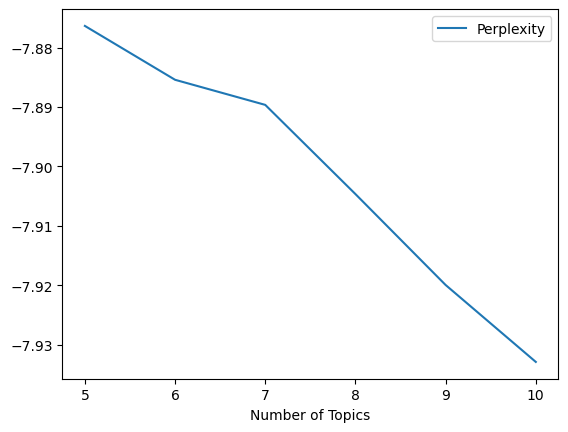

In [73]:
model_result.plot.line(y='Perplexity', x='Number of Topics')

- Perplexity is calculated by taking the log likelihood of unseen text documents given the topics defined by a topic model.
- A good model will have a high likelihood and resultantly low perplexity.
- But sometimes these metrics are not correlated with human interpretability of the model, which can be impractical in a business setting.


From 5 to 10 topics, the perplexity score decreased linearly from 5 to 10 topics.

Although a lower perplexity score is better, a lower perplexity score is achieved as there will be less unique topics in each document. Since I want to ensure that the topics are still unqiue, I will look at the Coherence score instead.

<AxesSubplot:xlabel='Number of Topics'>

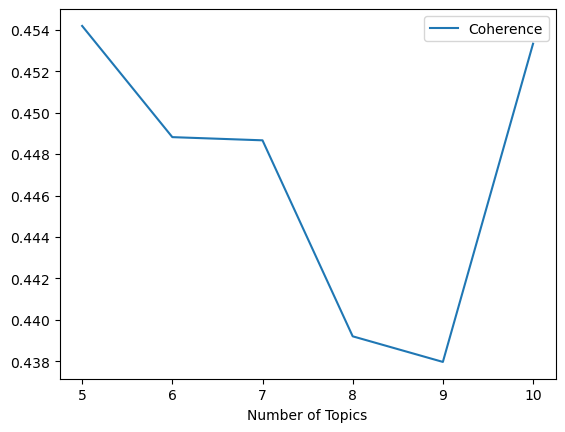

In [74]:
# Look for the highest coherence value
model_result.plot.line(y='Coherence', x='Number of Topics')

Topic coherence looks at a set of words in generated topics and rates the interpretability of the topics. The higher the value, the better the model.

When the number of topics is 5, the Coherence score is the highest, at 0.4541. Therefore, 5 topics is the best as it has the highest interpretability of the topics.

Since 5 topics has the highest coherence score, I will check out its intertopic distance

In [75]:
ldamodel = Lda(doc_term_matrix, num_topics = 5, id2word = dictionary, passes=10, random_state=42)

In [76]:
# Enter codes here
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the topics and keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

C:\Users\fangg\anaconda3_new\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\fangg\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.119595  0.108039       1        1  31.931896
0      0.117012 -0.015647       2        1  28.768360
2      0.102316 -0.019270       3        1  21.369577
3      0.103244 -0.075999       4        1  14.077585
4     -0.442168  0.002877       5        1   3.852581, topic_info=       Term          Freq         Total Category  logprob  loglift
2006    und   1990.000000   1990.000000  Default  30.0000  30.0000
2024    die   1695.000000   1695.000000  Default  29.0000  29.0000
739    mall   4509.000000   4509.000000  Default  28.0000  28.0000
71    store  28709.000000  28709.000000  Default  27.0000  27.0000
2654    ich   1456.000000   1456.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
3151   pour    384.666107    397.751932   Topic5  -5.4525   3.2230
5038    von    367.582098    381.048623   Topic5  -5.4979   3.2204
1444    war    377.416166    486.133391   Topic5  -5.4715   3.0033
637     man    719.554776   1725.220951   Topic5  -4.8262   2.3819
257     hat    304.075907    827.399880   Topic5  -5.6876   2.2554

[454 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
2008       5  0.996387       aber
3934       2  0.988555     adidas
7220       1  0.010212  admission
7220       2  0.010212  admission
7220       3  0.970182  admission
...      ...       ...        ...
4057       1  0.003174       yarn
4057       2  0.022217       yarn
4057       3  0.053955       yarn
4057       4  0.920402       yarn
19788      4  0.967289      yeast

[1256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

Topic 5 is well separated from the other 4 topics as the contents of topic 5 are German. (You can hover over it to see the top 30 terms in the topic on the right bar chart).

Topics 1 to 4 are clustered and have low intertopic distance. Hovering it, the bar chart on the right reveals some common terms among the 4 topics such as store, one, selection, etc.

Since the clusters in an intertopic distance map are close to each other, it could indicate that the topics in the text data are not well-separated and the topic modeling algorithm is struggling to differentiate between them. This can have **several possible causes:**

1. Insufficient number of topics: The model may not be able to capture the complexity and diversity of the text data if there are too few topics.
2. Overlapping topics: Overlapping topics among the texts may cause the clusters in the intertopic distance map to be close to each other. 
3. Noise in the dataset: If the text data contains a lot of noise, such as irrelevant words or irrelevant documents, it can cause the clusters in the intertopic distance map to be close to each other. 
4. Model complexity: A complex topic modelling algorithm may cause overfitting and not capturing the underlying topics. 


**Possible approaches that can be taken:**
* Increasing the number of topics may improve the separation of the clusters.
* Consider refining the preprocessing steps or the topic modeling algorithm to better separate the topics such as removing foreign languages.
* Consider filtering out irrelevant words or documents such as common words to improve the results.
* Consider using a simpler algorithm or adjusting the hyperparameters of the current algorithm to reduce complexity such as LSI model.

### Data Preparation 2  - Removing foreign languages and top 100 most common words.

In [77]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Store the texts a variable for processing
texts = [text for text in df['text']]

# Store the text's index
file_index = list(np.arange(df.shape[0]))

In [78]:
# Detect any foreign language and remove it to reduce noise in the data.

# pip install langdetect
from langdetect import detect

def keep_english_text(texts):
    counter = 0
    cleaned_texts = []
    for text in texts:
        language = detect(text)
        # Print at interval of 10000 to track progress of checks.
        if counter%10000==0:
            print(counter)
        if language == 'en':
            cleaned_texts.append(text)
        counter += 1
    return cleaned_texts

texts = keep_english_text(texts)

0
10000
20000
30000


In [79]:
# Clean the texts again by removing stopwords, punctuation, and normalize
def clean(doc):
    punc_free = ''.join([ch for ch in doc.lower() if ch not in exclude])
    stop_free = ' '.join([i for i in punc_free.split() if i not in stop])
    normalized = ' '.join(lemma.lemmatize(word) for word in stop_free.split())
    normalized = ' '.join(word for word in normalized.split() if len(word)>2 and not word.isdigit())
    return normalized

doc_clean = [clean(text).split() for text in texts]

In [80]:
print("Number of documents after removing documents that are not english:",len(doc_clean))

Number of documents after removing documents that are not english: 35315


In [81]:
# Tokenize the words to generate frequency of words.
from nltk.tokenize import word_tokenize

# Get the tokenized words
tokenized_word_list = [word for word_list in doc_clean for word in word_list]

# Generate word frequencies
all_words_frequency = nltk.FreqDist(tokenized_word_list)

In [82]:
print("Total number of terms in the document:",len(all_words_frequency))

Total number of terms in the document: 45557


In [83]:
print("Top 100 common words:",all_words_frequency.most_common(100))

Top 100 common words: [('store', 29064), ('like', 18563), ('one', 18282), ('place', 18133), ('get', 15892), ('time', 14795), ('great', 14356), ('good', 12702), ('shop', 12446), ('really', 11638), ('would', 11244), ('price', 11022), ('find', 10608), ('also', 9639), ('back', 9595), ('even', 8855), ('love', 8630), ('thing', 8355), ('selection', 8289), ('service', 8083), ('well', 7990), ('always', 7932), ('know', 7528), ('make', 7465), ('need', 7465), ('staff', 7452), ('item', 7256), ('day', 7094), ('nice', 7092), ('much', 6950), ('lot', 6917), ('new', 6904), ('little', 6687), ('people', 6649), ('looking', 6448), ('buy', 6355), ('could', 6197), ('look', 6160), ('around', 6133), ('customer', 5923), ('come', 5916), ('want', 5826), ('something', 5797), ('got', 5769), ('sale', 5668), ('see', 5667), ('never', 5561), ('pretty', 5549), ('friendly', 5545), ('year', 5462), ('went', 5433), ('best', 5415), ('going', 5368), ('stuff', 5356), ('way', 5187), ('location', 5186), ('everything', 5003), ('th

Most of the top 100 words are quite commonly used terms in the shopping industry. These words are too common and therefore will be removed for the model to be able to separate the topics better.

In [84]:
# Get the top 100 common words for removal
common_words = [word for (word,value) in all_words_frequency.most_common(100)]

In [85]:
print(common_words)

['store', 'like', 'one', 'place', 'get', 'time', 'great', 'good', 'shop', 'really', 'would', 'price', 'find', 'also', 'back', 'even', 'love', 'thing', 'selection', 'service', 'well', 'always', 'know', 'make', 'need', 'staff', 'item', 'day', 'nice', 'much', 'lot', 'new', 'little', 'people', 'looking', 'buy', 'could', 'look', 'around', 'customer', 'come', 'want', 'something', 'got', 'sale', 'see', 'never', 'pretty', 'friendly', 'year', 'went', 'best', 'going', 'stuff', 'way', 'location', 'everything', 'think', 'shopping', 'first', 'work', 'mall', 'found', 'take', 'say', 'right', 'every', 'still', 'many', 'shoe', 'book', 'better', 'helpful', 'dress', 'help', 'made', 'said', 'since', 'two', 'experience', 'home', 'sure', 'product', 'bit', 'food', 'feel', 'area', 'though', 'check', 'big', 'ever', 'give', 'anything', 'guy', 'definitely', 'room', 'another', 'quality', 'told', 'friend']


In [86]:
for index in range(len(doc_clean)):
    uncommon = []
    for words in doc_clean[index]:
        if words not in common_words:
            uncommon.append(words)
    doc_clean[index] = uncommon

In [87]:
# Creating the term matrix
dictionary = corpora.Dictionary(doc_clean) # unique terms

# Creating term count
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [166]:
# To ensure sufficient but not too much topics, I will test topics in range 5 to 10 with intervals of 1.
topic_num_list = list(np.arange(5,11,1))

In [167]:
topic_num_list

[5, 6, 7, 8, 9, 10]

In [90]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
from pprint import pprint
from gensim.models import CoherenceModel

no_topic_tested = []
perplexity_scores = []
coherence_score = []
Lda = gensim.models.LdaMulticore
for number_of_topics in topic_num_list:
    print("Testing with",number_of_topics,"topics.")
#     print("Running the LDA Model")
    ldamodel = Lda(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, passes=10, random_state=42)
    # The default number of passes is 1.
    # A higher pass also means the model learns more from the data. 
    # However, the model will become computationally expensive and time consuming.
    # To reduce the computational time while ensuring sufficient iterations are made, I will use only 10 passes.

    # random_state is passed to ensure reproducable results for training and tuning.

    perplexity_score = ldamodel.log_perplexity(doc_term_matrix)

    # Coherence c_v is generally the most interpretable, therefore I set the coherence to c_v.
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
    no_topic_tested.append(number_of_topics)
    perplexity_scores.append(float(perplexity_score))
    coherence_score.append(coherence_model_lda.get_coherence())
    print()

model_result = pd.DataFrame({'Number of Topics':no_topic_tested, 'Perplexity':perplexity_scores, 'Coherence':coherence_score})
model_result.sort_values(by='Coherence', ascending=False)

Testing with 5 topics.

Testing with 6 topics.

Testing with 7 topics.

Testing with 8 topics.

Testing with 9 topics.

Testing with 10 topics.



,Number of Topics,Perplexity,Coherence
2,7,-8.418336,0.466430
3,8,-8.438130,0.455485
4,9,-8.452366,0.443432
5,10,-8.466045,0.425303
1,6,-8.417370,0.413743
0,5,-8.425757,0.399982


<AxesSubplot:xlabel='Number of Topics'>

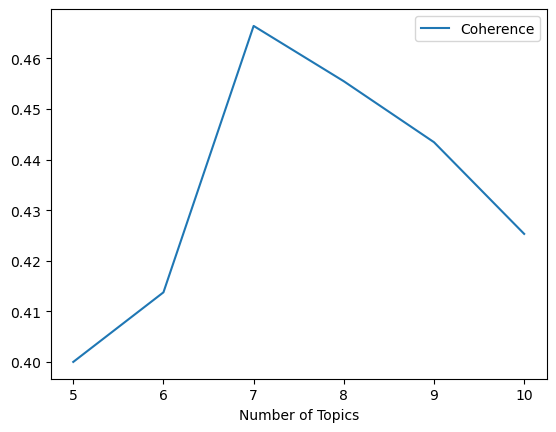

In [91]:
# Look for the highest coherence value
model_result.plot.line(y='Coherence', x='Number of Topics')

Since 7 topics has the highest coherence score of 0.4664, I will check out its intertopic distance

In [92]:
ldamodel = Lda(doc_term_matrix, num_topics = 7, id2word = dictionary, passes=10, random_state=42)

In [93]:
# Enter codes here
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the topics and keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

C:\Users\fangg\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.134183 -0.090408       1        1  26.074791
6     -0.042331  0.067746       2        1  18.336595
2      0.088745 -0.062403       3        1  14.361588
3      0.014796  0.068361       4        1  12.409610
0      0.007230  0.091649       5        1  11.427689
1     -0.025294 -0.012233       6        1   9.814780
4      0.091036 -0.062712       7        1   7.574947, topic_info=          Term         Freq        Total Category  logprob  loglift
359       gift  2964.000000  2964.000000  Default  30.0000  30.0000
729       hair  1842.000000  1842.000000  Default  29.0000  29.0000
641    clothes  3051.000000  3051.000000  Default  28.0000  28.0000
2284      bike  2897.000000  2897.000000  Default  27.0000  27.0000
212   clothing  2526.000000  2526.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
819        use   264.966393  2072.849535   Topic7  -6.1124   0.5232
2812       bar   249.984506  1355.418397   Topic7  -6.1706   0.8899
199        etc   257.919876  2207.122722   Topic7  -6.1393   0.4335
498       show   253.068156  1741.530733   Topic7  -6.1583   0.6515
455      small   253.591325  3165.446425   Topic7  -6.1563   0.0560

[611 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
650       1  0.097196  accessory
650       2  0.554876  accessory
650       3  0.005536  accessory
650       4  0.055980  accessory
650       5  0.220228  accessory
...     ...       ...        ...
4102      4  0.009414       yoga
4102      5  0.021965       yoga
4102      6  0.753080       yoga
4102      7  0.009414       yoga
6183      4  0.993444        zia

[2458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 3, 4, 1, 2, 5])

With 100 most common words removed and only english texts left in the dataframe, the topics are now much more easy to interpret and the intertopic distance is now larger. This is a good progress as compared to the previous intertopic distance map, where all topic are clustered together in the left quadrants.

However, there are topics that are overlapping and does not have high intertopic distance. Therefore, further tuning needs to be made.

### Data Preparation 3  - Removing foreign languages, top 100 most common words, and Lemmatizer.

Lemmatization reduces words to their base form, which can result in loss of context and semantic information. Removing lemmatization can help preserve the context and semantic meaning of words, leading to more interpretable and coherent topics.

In some cases, leaving words in their original form can lead to better performance, as different variations of words can carry distinct meanings.

Therefore, I try leaving the word in their original form.

In [150]:
# Clean the texts again by removing stopwords, punctuation
def clean(doc):
    punc_free = ''.join([ch for ch in doc.lower() if ch not in exclude])
    stop_free = ' '.join([i for i in punc_free.split() if i not in stop])
    return stop_free

doc_clean = [clean(text).split() for text in texts]

In [151]:
print("Number of documents after removing documents that are not english:",len(doc_clean))

Number of documents after removing documents that are not english: 35315


In [152]:
# Tokenize the words to generate frequency of words.
from nltk.tokenize import word_tokenize

# Get the tokenized words
tokenized_word_list = [word for word_list in doc_clean for word in word_list]

# Generate word frequencies
all_words_frequency = nltk.FreqDist(tokenized_word_list)

In [153]:
print("Top 70 common words:",all_words_frequency.most_common(70))

Top 100 common words: [('store', 23229), ('like', 18295), ('one', 17126), ('place', 16234), ('get', 15003), ('great', 14347), ('good', 11947), ('time', 11887), ('really', 11638), ('go', 11504), ('would', 11244), ('find', 10238), ('shop', 9750), ('also', 9639), ('back', 9547), ('even', 8853), ('love', 8272), ('well', 7976), ('always', 7932), ('selection', 7872), ('service', 7678), ('staff', 7413), ('nice', 7092), ('much', 6950), ('new', 6904), ('know', 6887), ('little', 6686), ('people', 6614), ('looking', 6447), ('buy', 6205), ('could', 6197), ('prices', 6187), ('around', 6133), ('need', 6053), ('stores', 5835), ('something', 5797), ('items', 5791), ('got', 5769), ('make', 5636), ('see', 5623), ('never', 5561), ('pretty', 5549), ('friendly', 5544), ('want', 5509), ('went', 5433), ('best', 5413), ('going', 5365), ('stuff', 5334), ('things', 5248), ('day', 5058), ('everything', 5003), ('shopping', 4995), ('first', 4987), ('way', 4983), ('think', 4899), ('look', 4892), ('lot', 4887), ('pr

In [154]:
# Get the top 70 common words for removal
common_words = [word for (word,value) in all_words_frequency.most_common(70)]

In [155]:
print(common_words)

['store', 'like', 'one', 'place', 'get', 'great', 'good', 'time', 'really', 'go', 'would', 'find', 'shop', 'also', 'back', 'even', 'love', 'well', 'always', 'selection', 'service', 'staff', 'nice', 'much', 'new', 'know', 'little', 'people', 'looking', 'buy', 'could', 'prices', 'around', 'need', 'stores', 'something', 'items', 'got', 'make', 'see', 'never', 'pretty', 'friendly', 'want', 'went', 'best', 'going', 'stuff', 'things', 'day', 'everything', 'shopping', 'first', 'way', 'think', 'look', 'lot', 'price', 'come', 'found', 'location', 'every', 'right', 'still', 'many', 'customer', 'better', 'us', 'helpful', 'made']


In [156]:
for index in range(len(doc_clean)):
    uncommon = []
    for words in doc_clean[index]:
        if words not in common_words:
            uncommon.append(words)
    doc_clean[index] = uncommon

In [157]:
# Creating the term matrix
dictionary = corpora.Dictionary(doc_clean) # unique terms

In [158]:
print("Number of unique terms in the dictionary after removing stopwords and punctuations:",len(dictionary))

Number of unique terms in the dictionary after removing stopwords and punctuations: 51913


In [159]:
# Creating term count
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [168]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
from pprint import pprint
from gensim.models import CoherenceModel

no_topic_tested = []
perplexity_scores = []
coherence_score = []
Lda = gensim.models.LdaMulticore
for number_of_topics in topic_num_list:
    print("Testing with",number_of_topics,"topics.")
#     print("Running the LDA Model")
    ldamodel = Lda(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, passes=10, random_state=42)
    # The default number of passes is 1.
    # A higher pass also means the model learns more from the data. 
    # However, the model will become computationally expensive and time consuming.
    # To reduce the computational time while ensuring sufficient iterations are made, I will use only 10 passes.

    # random_state is passed to ensure reproducable results for training and tuning.

#     print("Obtaining the Perplexity Score")
    perplexity_score = ldamodel.log_perplexity(doc_term_matrix)
#     print("Obtaining the Coherence Score")

    # Cv is generally the most interpretable, therefore I set the coherence to c_v.
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
    no_topic_tested.append(number_of_topics)
    perplexity_scores.append(float(perplexity_score))
    coherence_score.append(coherence_model_lda.get_coherence())
    print()

model_result = pd.DataFrame({'Number of Topics':no_topic_tested, 'Perplexity':perplexity_scores, 'Coherence':coherence_score})
model_result.sort_values(by='Coherence', ascending=False)

Testing with 5 topics.

Testing with 6 topics.

Testing with 7 topics.

Testing with 8 topics.

Testing with 9 topics.

Testing with 10 topics.



,Number of Topics,Perplexity,Coherence
1,6,-8.532139,0.431564
0,5,-8.521570,0.427473
3,8,-8.551945,0.423473
2,7,-8.539398,0.420558
4,9,-8.568346,0.405371
5,10,-8.584273,0.402327


<AxesSubplot:xlabel='Number of Topics'>

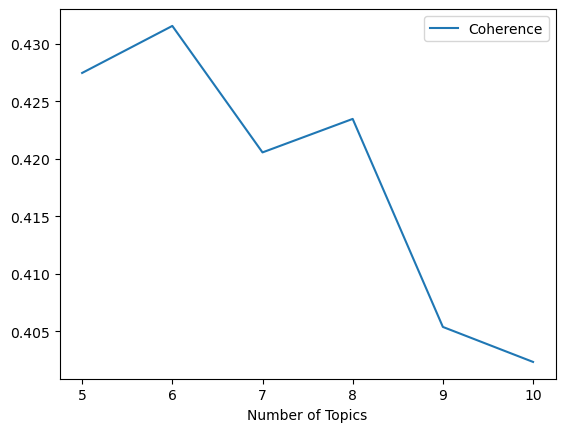

In [169]:
# Look for the highest coherence value
model_result.plot.line(y='Coherence', x='Number of Topics')

In [173]:
# tested 6 topics and had overlaps. therefore, testing 7 topics.
ldamodel = Lda(doc_term_matrix, num_topics = 7, id2word = dictionary, passes=10, random_state=42)

In [174]:
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the topics and keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

C:\Users\fangg\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.148842 -0.028104       1        1  24.066093
4      0.014398  0.049767       2        1  15.751574
2      0.097229 -0.046936       3        1  15.559711
3      0.005021 -0.038690       4        1  13.049904
5      0.012936 -0.095862       5        1  11.532696
1      0.047131  0.074038       6        1  11.482796
6     -0.027873  0.085787       7        1   8.557227, topic_info=          Term         Freq        Total Category  logprob  loglift
729       mall  4026.000000  4026.000000  Default  30.0000  30.0000
593      shoes  3287.000000  3287.000000  Default  29.0000  29.0000
723    clothes  3001.000000  3001.000000  Default  28.0000  28.0000
819       hair  1857.000000  1857.000000  Default  27.0000  27.0000
245   clothing  2469.000000  2469.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
147  different   374.685739  2928.097330   Topic7  -6.0051   0.4024
45        feel   373.294201  3225.612504   Topic7  -6.0088   0.3019
334        two   374.848636  4069.179844   Topic7  -6.0047   0.0737
534       area   364.006857  3319.170231   Topic7  -6.0340   0.2481
336     wanted   352.426223  3088.885785   Topic7  -6.0663   0.2877

[626 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
734        1  0.117849  accessories
734        2  0.068407  accessories
734        3  0.656299  accessories
734        4  0.027092  accessories
734        5  0.101594  accessories
...      ...       ...          ...
13719      5  0.937710          ysl
27698      3  0.969018       zenith
7093       2  0.938156          zia
7093       3  0.008452          zia
7093       5  0.042259          zia

[2424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 6, 2, 7])

7 Topics is the optimanl number of topics as the topics are quite well spread and have only 1 overlap between topics 2 and 6 which is related to clothes. This shows that the model is able to differentiate the topics well and create clusters that do not overlap alot with each other.

## Evaluation

Removing foreign languages, top 100 most common words, and Lemmatizer in the dataset and 7 topics is the best for topic modelling.

In [179]:
pprint(ldamodel.print_topics(num_topics=7, num_words=20))

[(0,
  '0.007*"said" + 0.007*"told" + 0.005*"bike" + 0.005*"help" + 0.005*"asked" + '
  '0.004*"phone" + 0.004*"called" + 0.004*"work" + 0.004*"wanted" + '
  '0.004*"experience" + 0.004*"needed" + 0.004*"another" + 0.004*"came" + '
  '0.004*"take" + 0.004*"took" + 0.004*"call" + 0.004*"minutes" + '
  '0.003*"business" + 0.003*"two" + 0.003*"sales"'),
 (1,
  '0.017*"mall" + 0.009*"hair" + 0.006*"parking" + 0.005*"vegas" + '
  '0.005*"food" + 0.004*"products" + 0.004*"shops" + 0.004*"area" + '
  '0.004*"books" + 0.003*"center" + 0.003*"city" + 0.003*"since" + 0.003*"cut" '
  '+ 0.003*"end" + 0.003*"salon" + 0.003*"court" + 0.003*"walk" + 0.003*"used" '
  '+ 0.003*"years" + 0.003*"located"'),
 (2,
  '0.009*"clothes" + 0.008*"clothing" + 0.005*"cute" + 0.004*"vintage" + '
  '0.004*"sale" + 0.004*"fun" + 0.004*"cool" + 0.004*"quality" + '
  '0.004*"accessories" + 0.003*"definitely" + 0.003*"furniture" + 0.003*"bit" '
  '+ 0.003*"unique" + 0.003*"dresses" + 0.003*"dress" + 0.003*"shoes" + '


* topic 0 seems to be about bikes
* topic 1 seems to be about malls
* topic 2 seems to be about clothes
* topic 3 seems to be about wedding decorations
* topic 4 seems to be about supermarkets
* topic 5 seems to be about shoes
* topic 6 seems to be about hotel weddings

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.